# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

In [34]:
import pandas as pd
import warnings

df = pd.read_csv('../data/hw2data.csv')

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

In [19]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

y = df['y']
X = df.drop('y', 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

In [31]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

alphas = np.logspace(-8, -3, 1000)
scores = []

for alpha in alphas:
    pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha = alpha))])
    pipe.fit(X_train, y_train)
    
    scores.append(pipe.score(X_test, y_test))

best_alpha = np.argmax(scores)
alpha_optim = alphas[best_alpha]

print("best regularization strenght", alpha_optim)




best regularization strenght 0.000891148232284


d) Plot the training perforamnce versus the testing performance, and observe whree the test performance is
maximized. I've written an outline of the code you need.

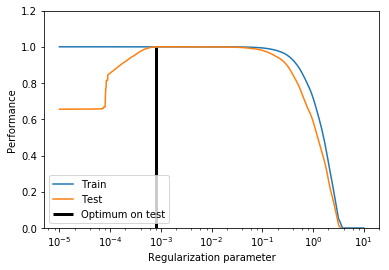

In [32]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

%matplotlib inline

# Fill these in
alphas = np.logspace(-5, 1, 1000)
train_errors=[]
test_errors=[]
alpha_optim=0

for alpha in alphas:
    pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha = alpha))])
    pipe.fit(X_train, y_train)
    
    train_errors.append(pipe.score(X_train, y_train))
    test_errors.append(pipe.score(X_test, y_test))
        
alpha_optim = alphas[np.argmax(test_errors)]  


plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')


plt.show()


e) Plot the top coefficients based on this optimal paramter. Why do you think so many are zero? 

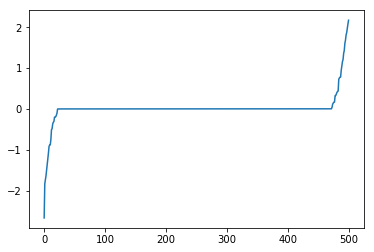

In [22]:
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha = alpha_optim))])
pipe.fit(X_train, y_train)

plt.plot(np.sort(pipe.named_steps['lasso'].coef_))
plt.show()



There are a lot of zeros, because as already mentioned during class, lasso's contraint region is a rectangular shape rather than a circular shape, thus there are more few points(also clustered rather than spread out) to become tangent to error functions.

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

[ 0.99984739  0.99999741  0.9999981   0.99999578  0.99997999]


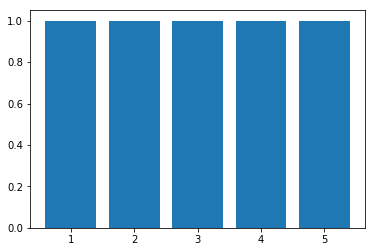

[ 0.99999847  0.99999572  0.99999229  0.99999396  0.99846348]


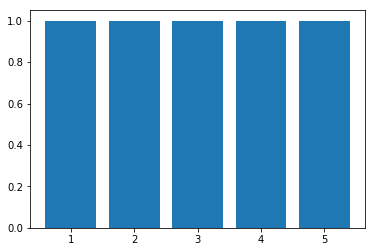

In [33]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, ShuffleSplit

pipe = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha = alpha_optim))])

scores = cross_val_score(pipe, X, y, cv=5)
print(scores)

plt.bar(range(1,6),scores)
plt.show()


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

scores = cross_val_score(pipe, X, y, cv= cv)
print(scores)

plt.bar(range(1,6),scores)
plt.show()

Works well for random subsets too.

f) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficiens obtained above. For this problem I"ll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [35]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_optim)

In [36]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

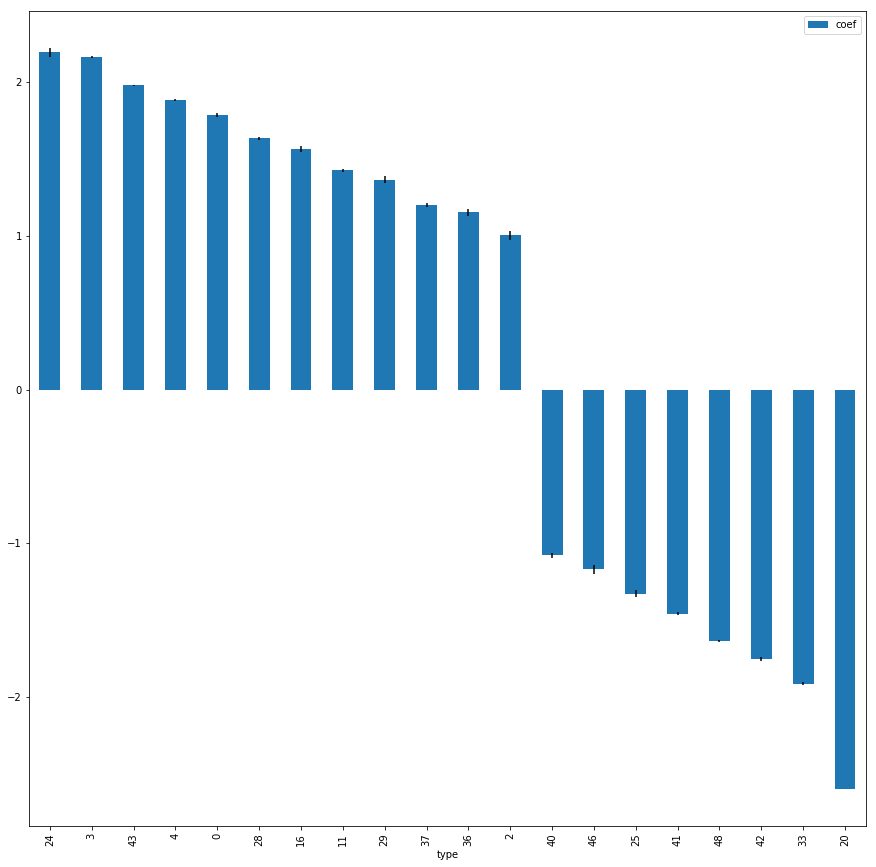

In [37]:
import warnings
warnings.filterwarnings("ignore")

dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))